# Import libraries

This notebook aims at analyzing the content of an E-commerce database that lists purchases made by  ∼ 4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). Based on this analysis, I develop a model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase

# Data Preperation 

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import re

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import collections
from collections import Counter
from collections import defaultdict
import itertools

from scipy import stats
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
df = pd.read_csv('rfm_data.csv', encoding = 'unicode_escape', dtype = {'CustomerID' : str})

# The first five rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850,United Kingdom


In [3]:
# The last five rows 

df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,12/9/2011 12:50,4.15,12680,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3.0,12/9/2011 12:50,4.95,12680,France


# Let's understand the columns names first, before we move on 

# Data Explorations:
### Columns Description :

* InvoiceNo : Unique ID for every time a consumer visits the store
* StockCode: Unique ID for a product
* Description : Description of the product
* Quantity : No of units bought
*InvoiceDate : Date and time of purchase
*Unit Price : Price for 1 unit of the product
*CustomerId : Unique ID for each customer
*Country : Country where transaction happened


* Also for our analysis we need to calculate the total sales for each product by multiplying Quantity with Unit Price. Also, convert Invoice Date in YYYYMM format.

In [4]:
print('The name of each column are below: \n')
i = 0 
for column_name in df.columns:
    i += 1
    print(f'{i}.', column_name)

The name of each column are below: 

1. InvoiceNo
2. StockCode
3. Description
4. Quantity
5. InvoiceDate
6. UnitPrice
7. CustomerID
8. Country


In [5]:
# I will change the names or the first letters of some columns in order to make it easy as i type

df.rename(index = str , 
          columns = {'InvoiceNo': 'invoice_num',
                    'StockCode' : 'stock_code',
                    'Description' : 'description',
                    'Quantity' : 'quantity',
                    'InvoiceDate' : 'invoice_date',
                    'UnitPrice' : 'unit_price',
                    'CustomerID' : 'customer_id',
                    'Country' : 'country'}, inplace=True)

In [6]:
# The data has 541909 entries and 8 variables

print('The shape of our dataset is,', df.shape)

The shape of our dataset is, (541909, 8)


In [7]:
print('Some info about our dataset is below: \n')
df.info()

Some info about our dataset is below: 

<class 'pandas.core.frame.DataFrame'>
Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_num   541909 non-null  object 
 1   stock_code    535874 non-null  object 
 2   description   534420 non-null  object 
 3   quantity      535874 non-null  float64
 4   invoice_date  535874 non-null  object 
 5   unit_price    535874 non-null  float64
 6   customer_id   403182 non-null  object 
 7   country       535874 non-null  object 
dtypes: float64(2), object(6)
memory usage: 37.2+ MB


In [8]:
print('Here are info about the type of each column: \n')
df.dtypes

Here are info about the type of each column: 



invoice_num      object
stock_code       object
description      object
quantity        float64
invoice_date     object
unit_price      float64
customer_id      object
country          object
dtype: object

## Dealing with the missing data

In [9]:
# One way in order to check for missing values, but i prefer the second

#df.isnull().any()

In [10]:
# As we can see we have a lot of missing data in this dataset
# However some of them is not really important, so we don't have problem so far

print('Here we can view the missing data in our dataset: \n')
df.isnull().sum()

Here we can view the missing data in our dataset: 



invoice_num          0
stock_code        6035
description       7489
quantity          6035
invoice_date      6035
unit_price        6035
customer_id     138727
country           6035
dtype: int64

In [11]:
print('Here we can view the percentage of the missing data in our dataset: \n')
missing_percentage = ( df.isnull().sum() / df.shape[0] ) * 100
missing_percentage

Here we can view the percentage of the missing data in our dataset: 



invoice_num      0.000000
stock_code       1.113656
description      1.381966
quantity         1.113656
invoice_date     1.113656
unit_price       1.113656
customer_id     25.599686
country          1.113656
dtype: float64

* As we can see above almost the 26% of the customers are unknown!
* Moreover, we have 1.1% of the other columns missing
* We have to dig deaper in order to understand more our dataset

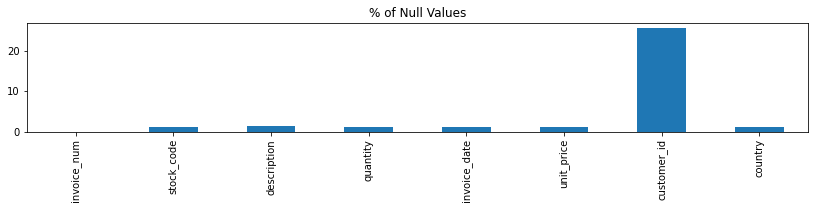

In [12]:
fig,ax = plt.subplots( figsize=(14,2))
((df.isnull().sum() / len(df))*100).plot.bar(ax=ax)
ax.set_title('% of Null Values')
plt.show()

In [13]:
# Drop the missing values 

df.dropna(inplace=True)
print('Missing Values: {}'.format(df.isnull().sum().sum()))

Missing Values: 0


In [14]:
#Double check it, just in case

df.isnull().sum()

invoice_num     0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

In [15]:
# Deal with the duplicates 

df.drop_duplicates(inplace = True)

In [16]:
# If you check the firest shape we had many duplicates 

df.shape

(398003, 8)

In [17]:
### ALLAGH THESIS AVRIO 

(df['customer_id'].isnull()) & (df['description'].isnull()).value_counts().sum()

0         False
1         False
2         False
3         False
4         False
          ...  
541904    False
541905    False
541906    False
541907    False
541908    False
Name: customer_id, Length: 398003, dtype: bool

### Time

In [18]:
# Change the format of the invoice_date 

df['invoice_date'] = pd.to_datetime(df['invoice_date']).dt.strftime('%m/%d/%y %h%m%s')

In [19]:
print("The datafile starts with timepoint {} \n".format(df['invoice_date'].min()))
print("The datafile ends with timepoint {}".format((df['invoice_date'].max())))

The datafile starts with timepoint 2010-12-01 08:26:00 

The datafile ends with timepoint 2011-12-09 12:50:00


In [20]:
df.dtypes

invoice_num      object
stock_code       object
description      object
quantity        float64
invoice_date     object
unit_price      float64
customer_id      object
country          object
dtype: object

### Explore the data 

In [21]:
print('Below are the unique name of the countries: \n')

i = 0 
for country_name in df['country'].unique() :
    
    i += 1
    print(f'{i}.', country_name)

Below are the unique name of the countries: 

1. United Kingdom
2. France
3. Australia
4. Netherlands
5. Germany
6. Norway
7. EIRE
8. Switzerland
9. Spain
10. Poland
11. Portugal
12. Italy
13. Belgium
14. Lithuania
15. Japan
16. Iceland
17. Channel Islands
18. Denmark
19. Cyprus
20. Sweden
21. Austria
22. Israel
23. Finland
24. Greece
25. Singapore
26. Lebanon
27. United Arab Emirates
28. Saudi Arabia
29. Czech Republic
30. Canada
31. Unspecified
32. Brazil
33. USA
34. European Community
35. Bahrain
36. Malta
37. RSA


In [22]:
print('In general the total numbers of the countries are:' , i)

In general the total numbers of the countries are: 37


In [23]:
# How many unique product are there?

missing_items = df['stock_code'].nunique()

print(f'There are {missing_items} missing items')

There are 3603 missing items


In [24]:
# How many of each product are there?

df['stock_code'].value_counts().head()

85123A    2065
22423     1894
85099B    1659
47566     1409
84879     1405
Name: stock_code, dtype: int64

In [25]:
# Sort the 5 most ordered products from most to least.

most_wanted = df['stock_code'].value_counts().sort_values(ascending=False)

print('The most wanted items in the dataset are \n')
most_wanted.head()

The most wanted items in the dataset are 



85123A    2065
22423     1894
85099B    1659
47566     1409
84879     1405
Name: stock_code, dtype: int64

In [26]:
# Sort the 5 not most ordered products from most to least.

not_most_wanted = df['stock_code'].value_counts().sort_values(ascending=True)

print('The most not wanted items in the dataset are \n')
not_most_wanted.head()

The most not wanted items in the dataset are 



90130A    1
90048     1
35610B    1
37471     1
35610C    1
Name: stock_code, dtype: int64

In [27]:
# But what kinf of products are these ? 
print('Below are the top five items we have: \n')

most_wanted_item = df.groupby('stock_code')['description'].value_counts().sort_values(ascending=False)
most_wanted_item.head()

Below are the top five items we have: 



stock_code  description                       
85123A      WHITE HANGING HEART T-LIGHT HOLDER    2058
22423       REGENCY CAKESTAND 3 TIER              1894
85099B      JUMBO BAG RED RETROSPOT               1659
47566       PARTY BUNTING                         1409
84879       ASSORTED COLOUR BIRD ORNAMENT         1405
Name: description, dtype: int64

In [28]:
# But what kinf of products are these ? 
print('Below are the last five items we have: \n')

most_wanted_item = df.groupby('stock_code')['description'].value_counts().sort_values(ascending=True)
most_wanted_item.head()

Below are the last five items we have: 



stock_code  description                    
84877A      PINK ROUND COMPACT MIRROR          1
90165B      WHITE ROSEBUD  PEARL EARRINGS      1
84569C      PACK 4 FLOWER/BUTTERFLY PATCHES    1
90167       BEADED LOVE HEART JEWELLERY SET    1
84551       CROCHET DOG KEYRING                1
Name: description, dtype: int64

In [29]:
# The number of canceled orders 
# In the data description we can find that a cancelled transactions starts with a "C" in front of it. 
# Let's create a feature to easily filter out these cases:

canceled = (df["invoice_num"].str.contains("C", na=False)).sum()

print('The total number of items that was canceled are', canceled)


The total number of items that was canceled are 8807


In [30]:
per_canceled = ((canceled / df.shape[0]) * 100 ).round(2)
print('The percentage of canceled orders is ',per_canceled , '%')

The percentage of canceled orders is  2.21 %


In [31]:
# I am checking if there is negative quantity in tha data 

flag = False
if (df['quantity'] < 0).any(): 
    flag = True
    print(flag)

True


In [32]:
asd = df[df['quantity'] < 0]
asd.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1.0,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1.0,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12.0,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24.0,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24.0,2010-12-01 10:24:00,0.29,17548,United Kingdom


### Cancelled Orders & Quantity

In [33]:
df["TotalPrice"] = df["quantity"] * df["unit_price"]

### Calculation of RFM metrics

* Recency : the number of days between today_date and the last purchase date of this customer

* Frequency : the number of purchase of this customer

* Monetary : sum of TotalPrice of this customer